In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import sys

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), os.pardir))

In [2]:
import glob
import json

import numpy as np
import tensorflow as tf

tf.keras.backend.set_floatx("float64")
tf.config.set_visible_devices([], "GPU")

import levenberg_marquardt as lm

In [3]:
def scale(t, t_min, t_max):
    t_scaled = 2 * (t - t_min) / (t_max - t_min) - 1
    np.nan_to_num(t_scaled, copy=False)
    return t_scaled

def inverse_scale(t_scaled, t_min, t_max):
    t = (t_scaled + 1) * (t_max - t_min) / 2 + t_min
    return t

In [4]:
config_json = "/home/jhli/CQPES-legacy/config/train.json"
workdir = "/home/jhli/CQPES-legacy/model-2024-06-29 16:24:34.294319"

In [5]:
with open(config_json) as f:
    config = json.load(f)

config

{'data': '/home/jhli/CQPES-legacy/data',
 'network': {'layers': [20, 20], 'activation': 'tanh'},
 'fit': {'lr': 0.5, 'epoch': 1000, 'batch_size': -1},
 'lm': {'adaptive_scaling': True,
  'fletcher': False,
  'solve_method': 'solve',
  'jacobian_max_num_rows': 500},
 'split': [0.9, 0.05, 0.05],
 'workdir': 'model'}

In [6]:
# load data
X = np.load(os.path.join(config["data"], "X.npy"))[:, 1:]
y = np.load(os.path.join(config["data"], "y.npy")).reshape((-1, 1))
V = np.load(os.path.join(config["data"], "V.npy")).reshape((-1, 1))

V_min = np.load(os.path.join(config["data"], "V_min.npy"))
V_max = np.load(os.path.join(config["data"], "V_max.npy"))

In [7]:
# load train, valid, & test
train_idx = np.loadtxt(os.path.join(workdir, "train_idx.txt"), dtype=np.int32)
valid_idx = np.loadtxt(os.path.join(workdir, "valid_idx.txt"), dtype=np.int32)
test_idx = np.loadtxt(os.path.join(workdir, "test_idx.txt"), dtype=np.int32)

In [8]:
# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(
        shape=(len(X[0]),)
    ),
)

for num_units in config["network"]["layers"]:
    model.add(
        tf.keras.layers.Dense(
            units=num_units,
            activation=config["network"]["activation"],
        ),
    )

model.add(
    tf.keras.layers.Dense(
        units=1,
        activation="linear"
    )
)

model_wrapper = lm.ModelWrapper(model)
model_wrapper.build(input_shape=(1, len(X[0])))
model_wrapper.load_weights(
    sorted(glob.glob(os.path.join(workdir, "ckpt", "*.h5")))[-1]
)

In [9]:
V_pred = inverse_scale(model_wrapper(X).numpy(), V_min, V_max)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

In [11]:
max_abs_error = np.abs(V_pred - V).max()
print(f"max |V_pred - V_true| = {max_abs_error * 1.0e+03:.2f} meV")

max |V_pred - V_true| = 35.45 meV


In [13]:
df_error = pd.DataFrame({
    "Dataset": ["train", "valid", "test", "total"],
    "MAE": [
        mean_absolute_error(V[train_idx] * 1.0e+03, V_pred[train_idx] * 1.0e+03),
        mean_absolute_error(V[valid_idx] * 1.0e+03, V_pred[valid_idx] * 1.0e+03),
        mean_absolute_error(V[test_idx] * 1.0e+03, V_pred[test_idx] * 1.0e+03),
        mean_absolute_error(V * 1.0e+03, V_pred * 1.0e+03),
    ],
    "MSE": [
        mean_squared_error(V[train_idx] * 1.0e+03, V_pred[train_idx] * 1.0e+03),
        mean_squared_error(V[valid_idx] * 1.0e+03, V_pred[valid_idx] * 1.0e+03),
        mean_squared_error(V[test_idx] * 1.0e+03, V_pred[test_idx] * 1.0e+03),
        mean_absolute_error(V * 1.0e+03, V_pred * 1.0e+03),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(V[train_idx] * 1.0e+03, V_pred[train_idx] * 1.0e+03)),
        np.sqrt(mean_squared_error(V[valid_idx] * 1.0e+03, V_pred[valid_idx] * 1.0e+03)),
        np.sqrt(mean_squared_error(V[test_idx] * 1.0e+03, V_pred[test_idx] * 1.0e+03)),
        np.sqrt(mean_squared_error(V * 1.0e+03, V_pred * 1.0e+03)),
    ],
})

df_error

,Dataset,MAE,MSE,RMSE
0,train,0.334669,0.702244,0.838000
1,valid,0.371475,1.407019,1.186179
2,test,0.339287,0.829761,0.910912
3,total,0.336740,0.336740,0.862469


In [14]:
import scienceplots
from matplotlib import pyplot as plt

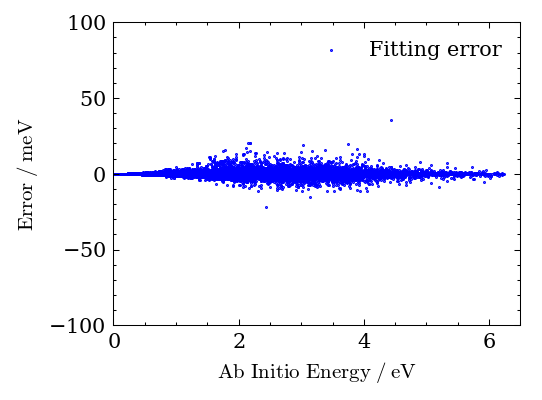

In [15]:
%matplotlib inline
import scienceplots
from matplotlib import pyplot as plt

with plt.style.context(["science", "no-latex"]):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)

    ax.scatter(V, (V_pred - V) * 1e3, s=0.2, c="b", label="Fitting error")
    ax.set_xlabel(r"$\mathrm{Ab \ Initio \ Energy \; / \; eV}$")

    ax.set_ylabel(r"$\mathrm{Error \; / \; meV}$")
    ax.set_xlim([0, 6.5])
    ax.set_ylim([-100, 100])
    plt.legend()